In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 16 - The BART model of risk taking

## 16.1 The BART model
Balloon Analogue Risk Task (BART: Lejuez et al., 2002): Every trial in this task starts by showing a balloon representing a small monetary value. The subject can then either transfer the money to a virtual bank account, or choose to pump, which adds a small amount of air to the balloon, and increases its value. There is some probability, however, that pumping the balloon will cause it to burst, causing all the money to be lost. A trial finishes when either the subject has transferred the money, or the balloon has burst.

$$ \gamma^{+} \sim \text{Uniform}(0,10) $$
$$ \beta \sim \text{Uniform}(0,10) $$
$$ \omega = -\gamma^{+} \,/\,\text{log}(1-p) $$
$$ \theta_{jk} = \frac{1} {1+e^{\beta(k-\omega)}} $$
$$ d_{jk} \sim \text{Bernoulli}(\theta_{jk}) $$

In [3]:
p = 0.15  # (Belief of) bursting probability
ntrials = 90  # Number of trials for the BART

Data = pd.read_csv("data/GeorgeSober.txt", sep="\t")
# Data.head()
cash = np.asarray(Data["cash"] != 0, dtype=int)
npumps = np.asarray(Data["pumps"], dtype=int)

options = cash + npumps

d = np.full([ntrials, 30], np.nan)
k = np.full([ntrials, 30], np.nan)
# response vector
for j, ipumps in enumerate(npumps):
    inds = np.arange(options[j], dtype=int)
    k[j, inds] = inds + 1
    if ipumps > 0:
        d[j, 0:ipumps] = 0
    if cash[j] == 1:
        d[j, ipumps] = 1

indexmask = np.isfinite(d)
d = d[indexmask]
k = k[indexmask]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gammap]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8815120110564919, but should be close to 0.8. Try to increase the number of tuning steps.


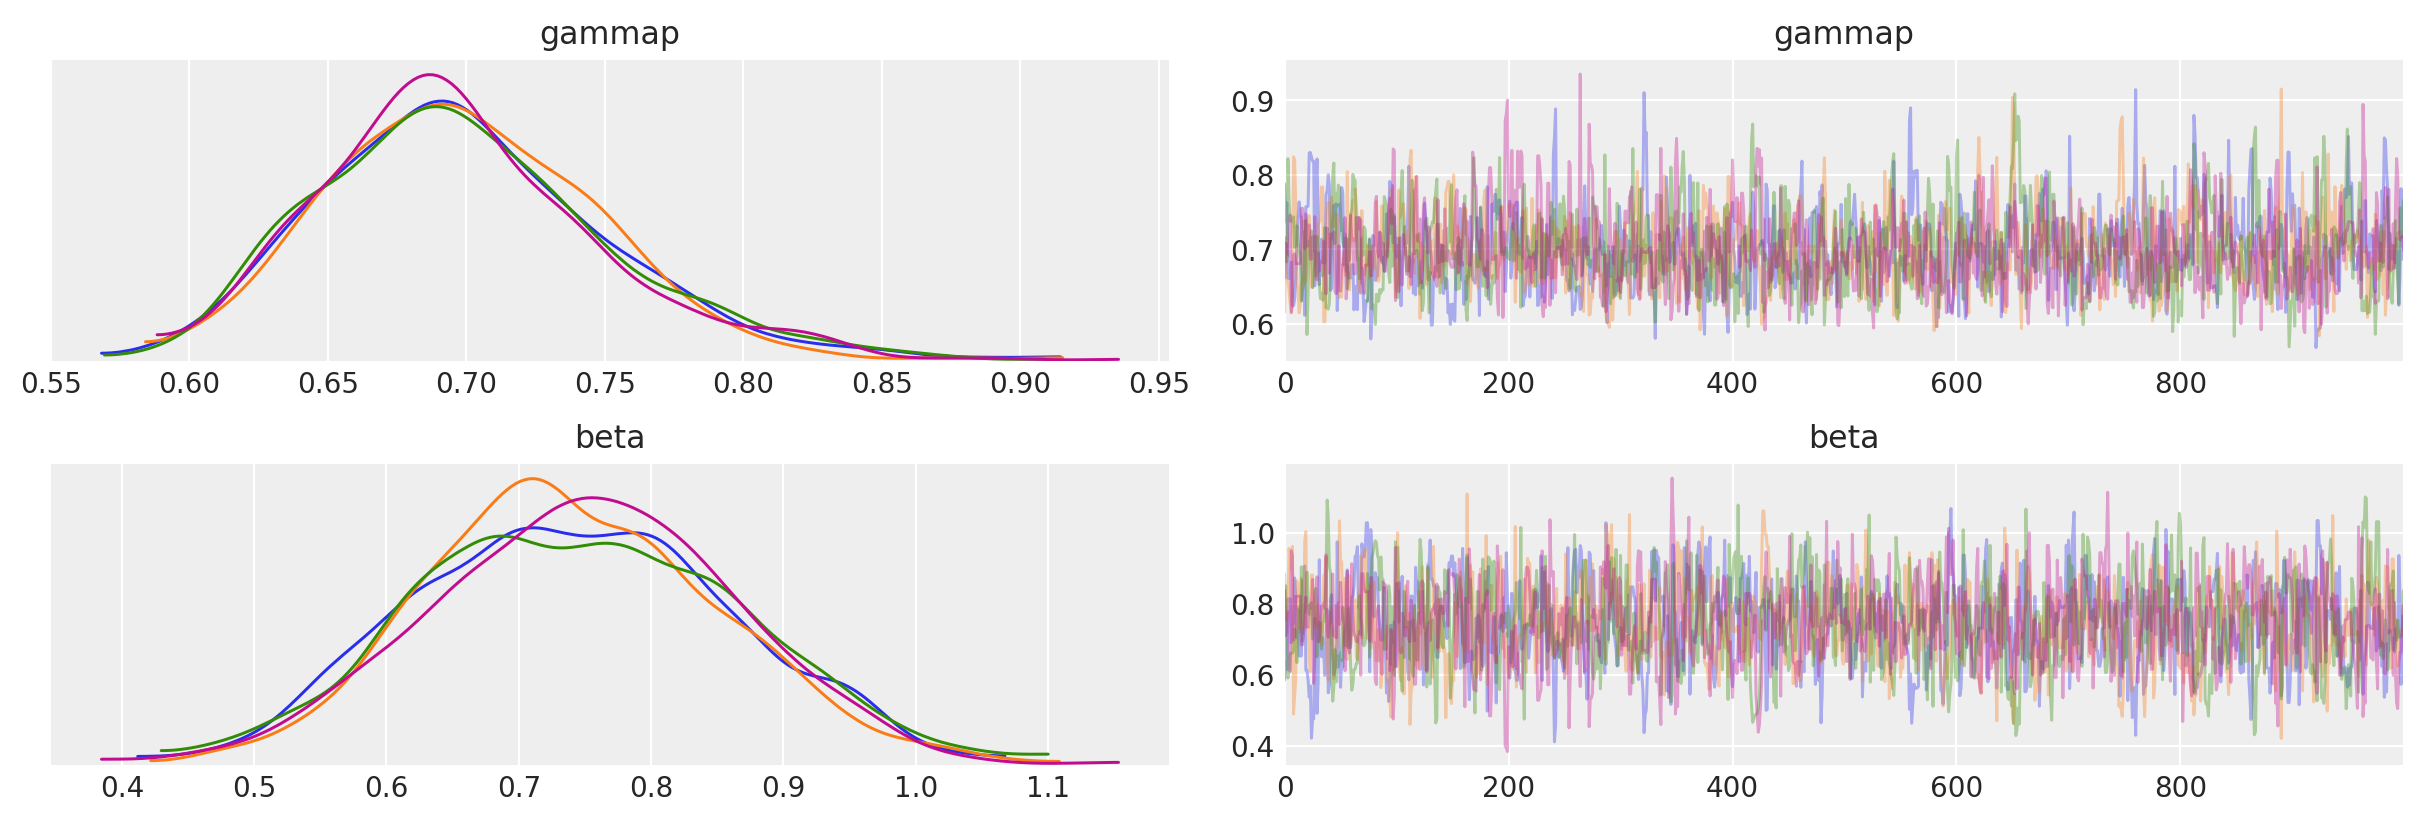

In [4]:
with pm.Model():
    gammap = pm.Uniform("gammap", lower=0, upper=10, testval=1.2)
    beta = pm.Uniform("beta", lower=0, upper=10, testval=0.5)
    omega = pm.Deterministic("omega", -gammap / np.log(1 - p))

    thetajk = 1 - pm.math.invlogit(-beta * (k - omega))

    djk = pm.Bernoulli("djk", p=thetajk, observed=d)

    trace = pm.sample(tune=2000)

az.plot_trace(trace, var_names=["gammap", "beta"]);

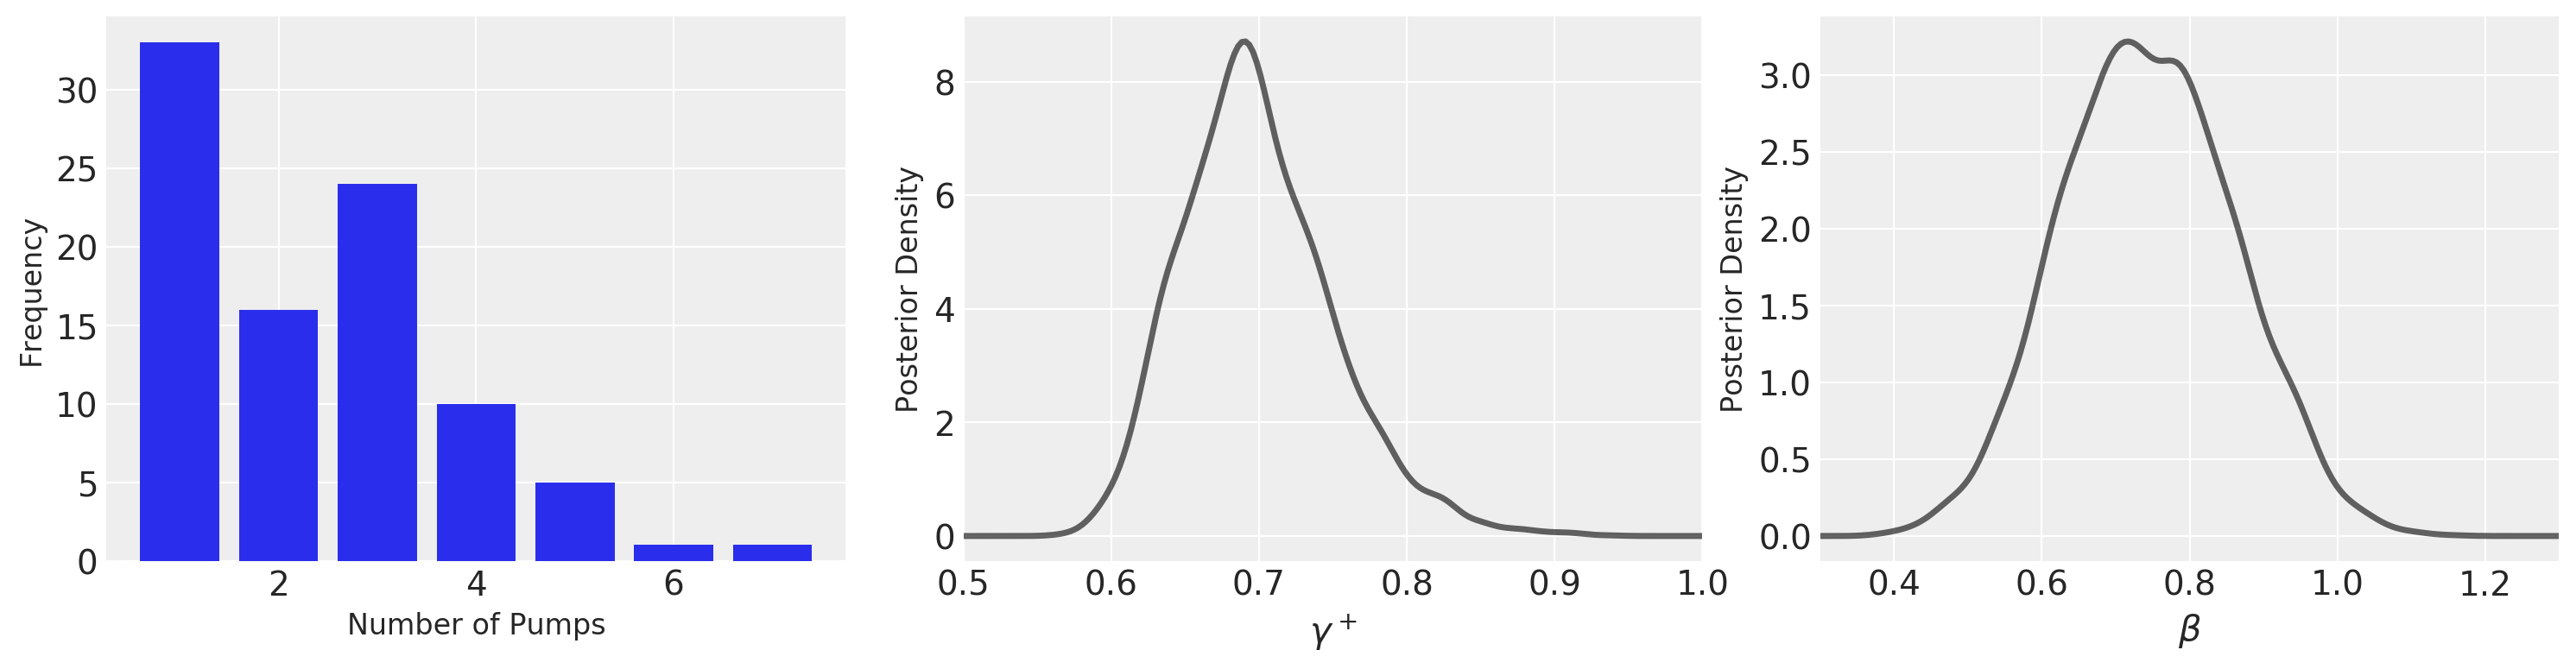

In [5]:
gammaplus = trace["gammap"]
beta = trace["beta"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(npumps, bins=range(1, 9), rwidth=0.8, align="left")
axes[0].set_xlabel("Number of Pumps", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

my_pdf1 = stats.kde.gaussian_kde(gammaplus)
x1 = np.linspace(0.5, 1, 200)
axes[1].plot(x1, my_pdf1(x1), "k", lw=2.5, alpha=0.6)  # distribution function
axes[1].set_xlim((0.5, 1))
axes[1].set_xlabel(r"$\gamma^+$", fontsize=15)
axes[1].set_ylabel("Posterior Density", fontsize=12)

my_pdf2 = stats.kde.gaussian_kde(beta)
x2 = np.linspace(0.3, 1.3, 200)
axes[2].plot(
    x2, my_pdf2(x2), "k", lw=2.5, alpha=0.6,
)  # distribution function
axes[2].set_xlim((0.3, 1.3))
axes[2].set_xlabel(r"$\beta$", fontsize=15)
axes[2].set_ylabel("Posterior Density", fontsize=12)

plt.tight_layout();

## 16.2 A hierarchical extension of the BART model
  
  
$$ \mu_{\gamma^{+}} \sim \text{Uniform}(0,10) $$
$$ \sigma_{\gamma^{+}} \sim \text{Uniform}(0,10) $$
$$ \mu_{\beta} \sim \text{Uniform}(0,10) $$
$$ \sigma_{\beta} \sim \text{Uniform}(0,10) $$
$$ \gamma^{+}_i \sim \text{Gaussian}(\mu_{\gamma^{+}}, 1/\sigma_{\gamma^{+}}^2) $$
$$ \beta_i \sim \text{Gaussian}(\mu_{\beta}, 1/\sigma_{\beta}^2) $$
$$ \omega_i = -\gamma^{+}_i \,/\,\text{log}(1-p) $$
$$ \theta_{ijk} = \frac{1} {1+e^{\beta_i(k-\omega_i)}} $$
$$ d_{ijk} \sim \text{Bernoulli}(\theta_{ijk}) $$

In [6]:
p = 0.15  # (Belief of) bursting probability
ntrials = 90  # Number of trials for the BART
Ncond = 3

dall = np.full([Ncond, ntrials, 30], np.nan)
options = np.zeros((Ncond, ntrials))
kall = np.full([Ncond, ntrials, 30], np.nan)
npumps_ = np.zeros((Ncond, ntrials))

for icondi in range(Ncond):
    if icondi == 0:
        Data = pd.read_csv("data/GeorgeSober.txt", sep="\t")
    elif icondi == 1:
        Data = pd.read_csv("data/GeorgeTipsy.txt", sep="\t")
    elif icondi == 2:
        Data = pd.read_csv("data/GeorgeDrunk.txt", sep="\t")
    # Data.head()
    cash = np.asarray(Data["cash"] != 0, dtype=int)
    npumps = np.asarray(Data["pumps"], dtype=int)
    npumps_[icondi, :] = npumps
    options[icondi, :] = cash + npumps
    # response vector
    for j, ipumps in enumerate(npumps):
        inds = np.arange(options[icondi, j], dtype=int)
        kall[icondi, j, inds] = inds + 1
        if ipumps > 0:
            dall[icondi, j, 0:ipumps] = 0
        if cash[j] == 1:
            dall[icondi, j, ipumps] = 1

indexmask = np.isfinite(dall)
dij = dall[indexmask]
kij = kall[indexmask]
condall = np.tile(np.arange(Ncond, dtype=int), (30, ntrials, 1))
condall = np.swapaxes(condall, 0, 2)
cij = condall[indexmask]

Finished [100%]: Average Loss = 418.28
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, gammap, sigma_b, mu_b, sigma_g, mu_g]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 20 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8975321919917923, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


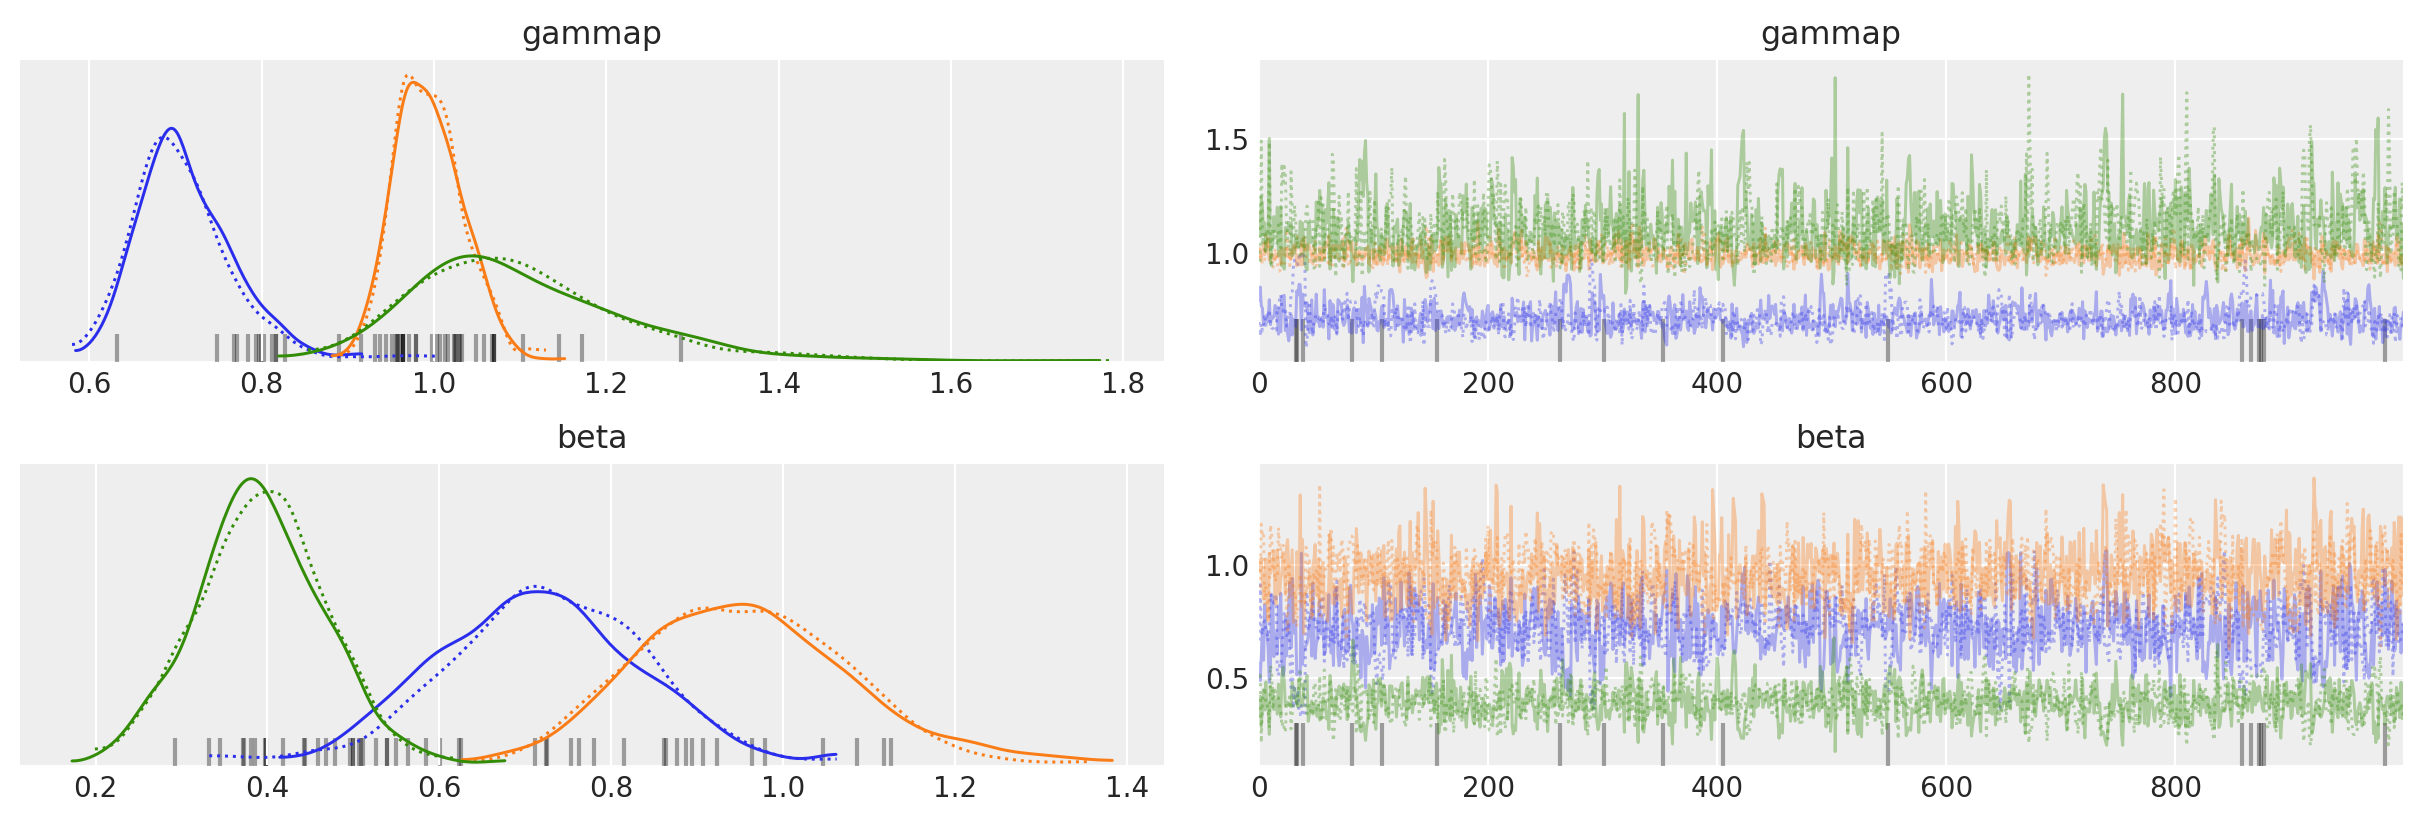

In [7]:
chains = 2
with pm.Model() as model2:
    mu_g = pm.Uniform("mu_g", lower=0, upper=10)
    sigma_g = pm.Uniform("sigma_g", lower=0, upper=10)
    mu_b = pm.Uniform("mu_b", lower=0, upper=10)
    sigma_b = pm.Uniform("sigma_b", lower=0, upper=10)

    gammap = pm.Normal("gammap", mu=mu_g, sd=sigma_g, shape=Ncond)
    beta = pm.Normal("beta", mu=mu_b, sd=sigma_b, shape=Ncond)

    omega = -gammap[cij] / np.log(1 - p)
    thetajk = 1 - pm.math.invlogit(-beta[cij] * (kij - omega))

    djk = pm.Bernoulli("djk", p=thetajk, observed=dij)

    approx = pm.fit(
        n=100000, method="advi", obj_optimizer=pm.adagrad_window
    )  # type: pm.MeanField
    start = approx.sample(draws=chains, include_transformed=True)
    trace2 = pm.sample(
         tune=2000, target_accept=0.95, chains=chains, init="adapt_diag", start=list(start)
    )

az.plot_trace(trace2, var_names=["gammap", "beta"], compact=True);

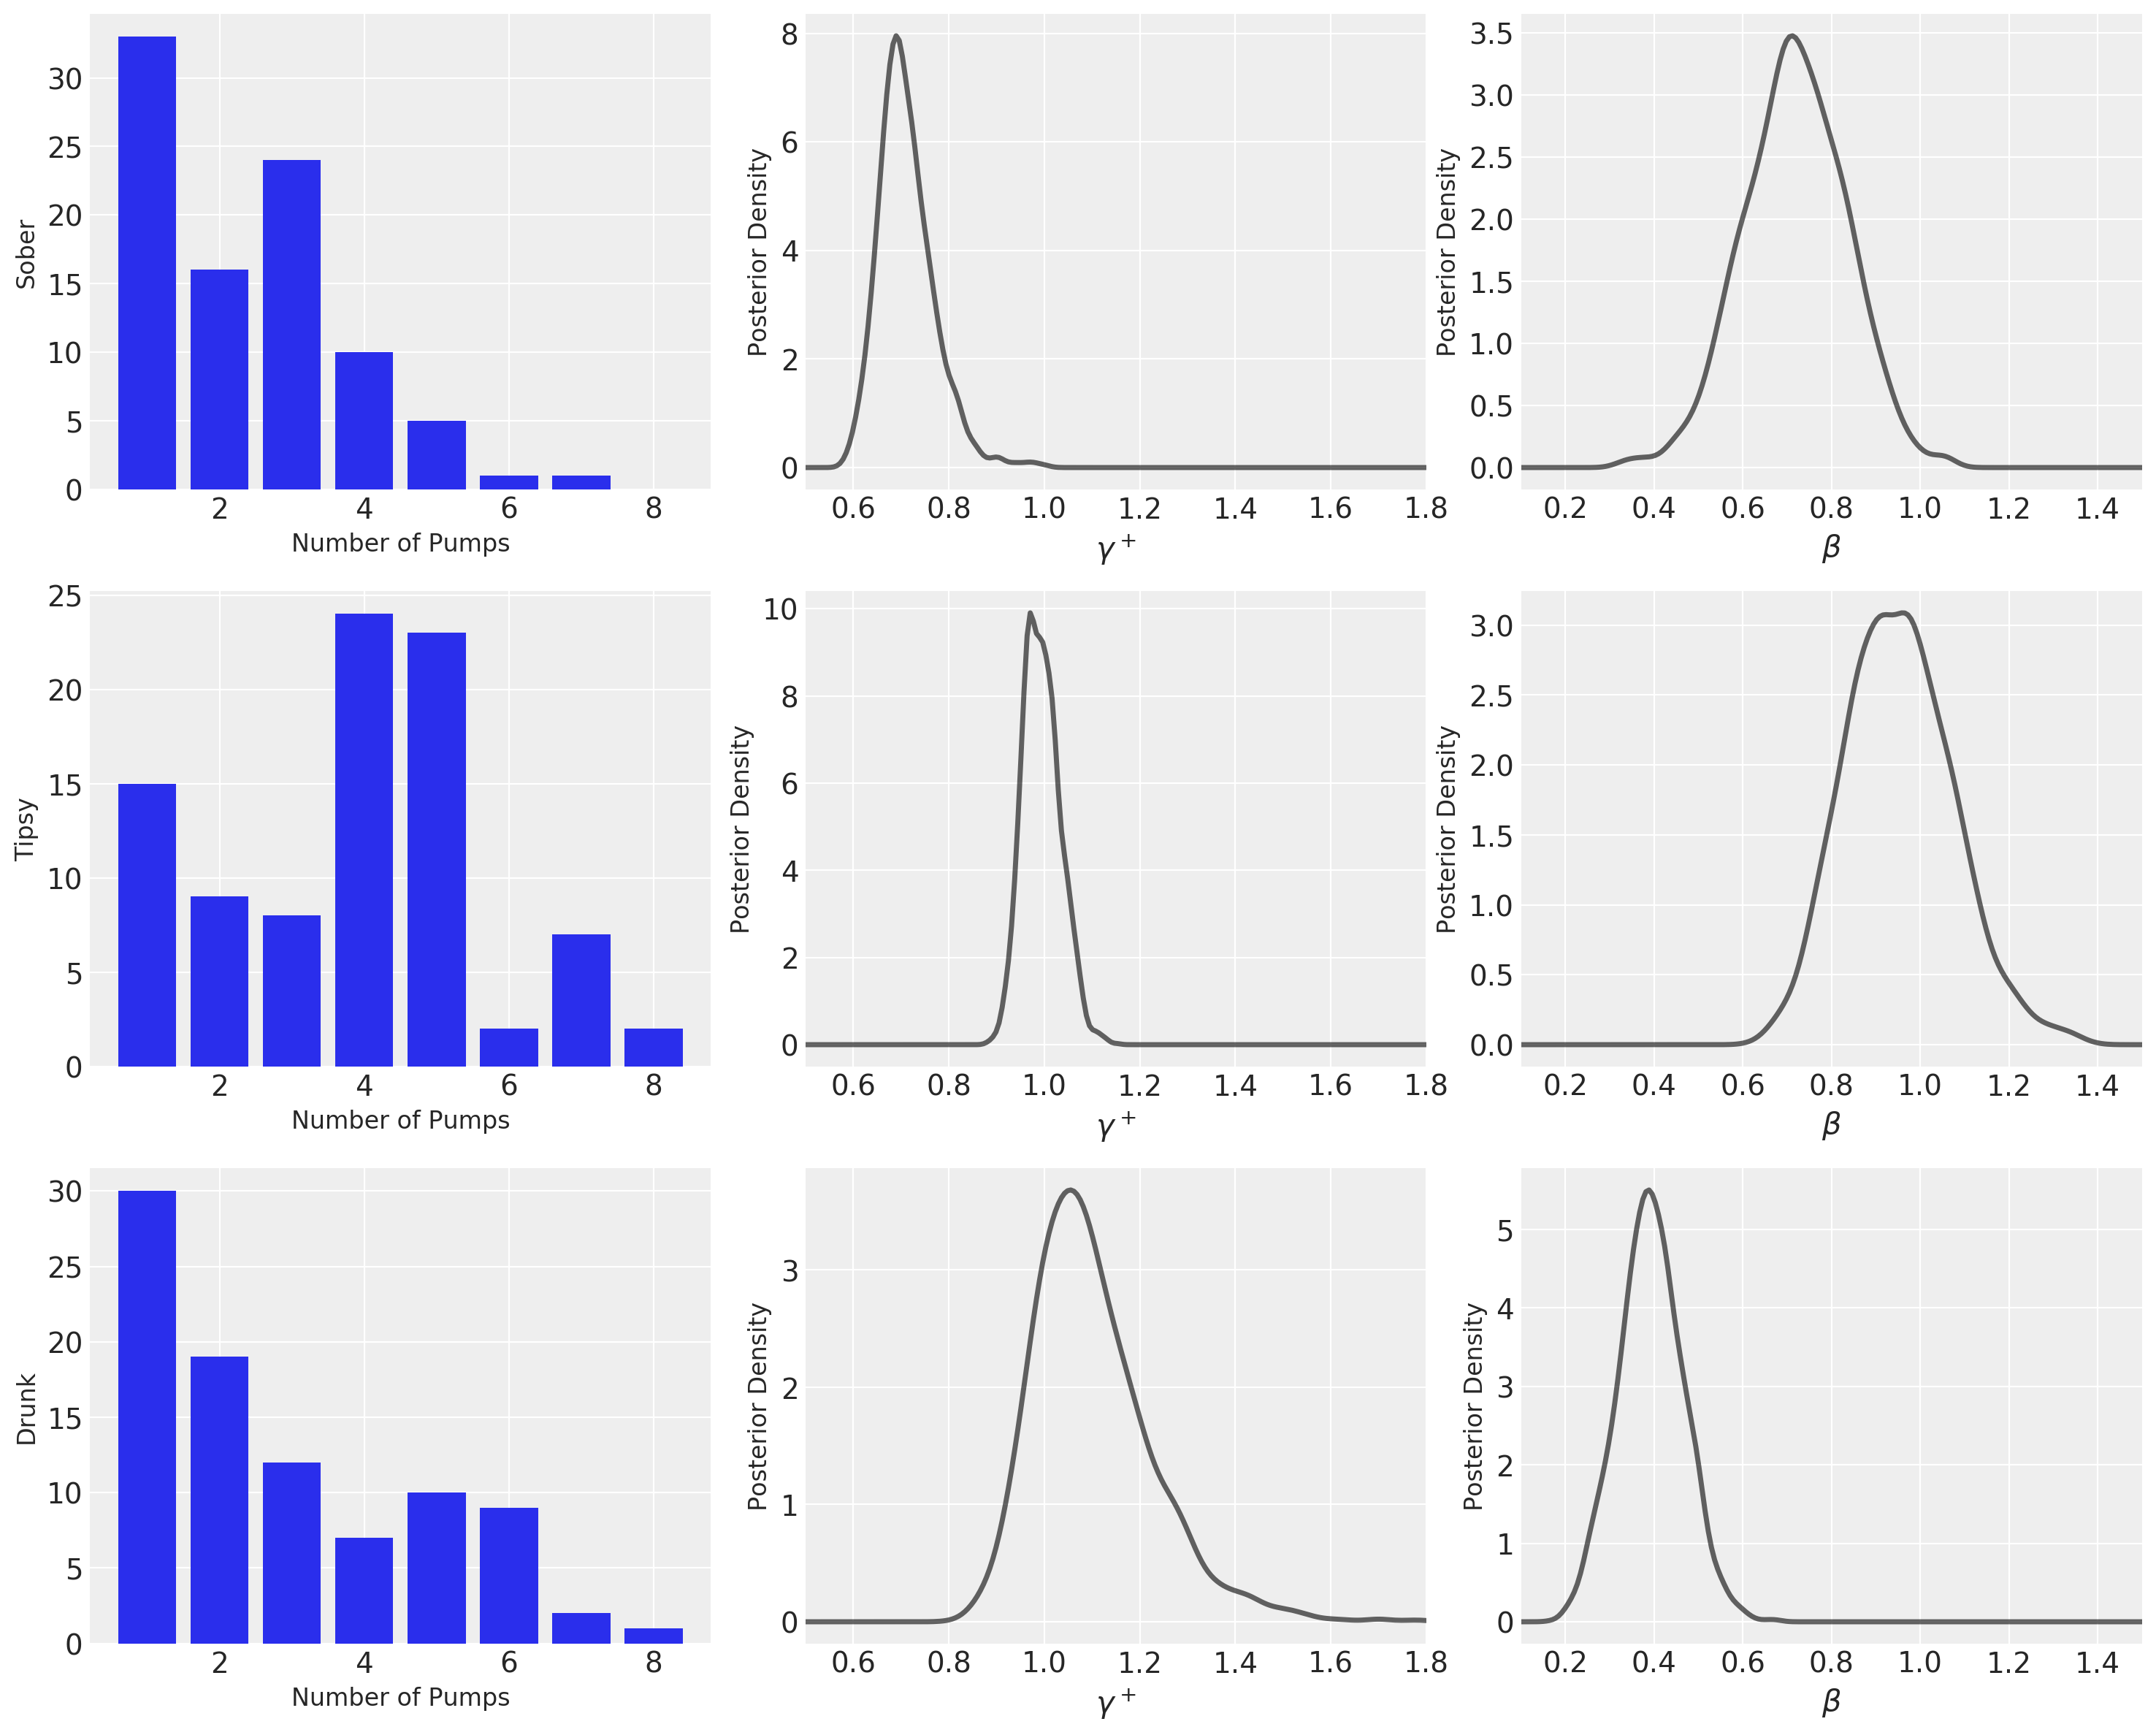

In [8]:
gammaplus = trace2["gammap"]
beta = trace2["beta"]
ylabels = ["Sober", "Tipsy", "Drunk"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for ic in range(Ncond):
    ax0 = axes[ic, 0]
    ax0.hist(npumps_[ic], bins=range(1, 10), rwidth=0.8, align="left")
    ax0.set_xlabel("Number of Pumps", fontsize=12)
    ax0.set_ylabel(ylabels[ic], fontsize=12)

    ax1 = axes[ic, 1]
    my_pdf1 = stats.kde.gaussian_kde(gammaplus[:, ic])
    x1 = np.linspace(0.5, 1.8, 200)
    ax1.plot(x1, my_pdf1(x1), "k", lw=2.5, alpha=0.6)  # distribution function
    ax1.set_xlim((0.5, 1.8))
    ax1.set_xlabel(r"$\gamma^+$", fontsize=15)
    ax1.set_ylabel("Posterior Density", fontsize=12)

    ax2 = axes[ic, 2]
    my_pdf2 = stats.kde.gaussian_kde(beta[:, ic])
    x2 = np.linspace(0.1, 1.5, 200)
    ax2.plot(x2, my_pdf2(x2), "k", lw=2.5, alpha=0.6)  # distribution function
    ax2.set_xlim((0.1, 1.5))
    ax2.set_xlabel(r"$\beta$", fontsize=15)
    ax2.set_ylabel("Posterior Density", fontsize=12)

plt.tight_layout();

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy  1.18.1
arviz  0.7.0
pymc3  3.8
pandas 1.0.3
last updated: Tue Apr 28 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
